In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import librosa.segment

from scipy import signal

import utils.VAD as vad

## Control Parameters:

In [3]:
sr = 48000 #sample rate

## Helper functions:

In [4]:
'''
Description:
    Plots the boundaries along with signal waveform. 
Parameters:
    waveform (numppy.ndarray): array of signal amplitudes
    boundaries (numppy.ndarray): array of waveform indices where boundaries exist
    sr (int): sample rate of waveform
Return:
    None

'''
def plot_boundaries_on_signal(signal, boundaries, sr):
    hi, lo = max(signal), min(signal) 
    no_samples = len(signal)
    plt.vlines(boundaries/sr, lo, hi, colors='Red', linestyles='dotted')
    plt.plot(np.linspace(0, no_samples/sr, no_samples), signal)

In [5]:
'''
Description:
    Splices a signal to [t1, t2), and optionally adjusts the boundary indices to the spliced signal.
Parameters:
    signal (numpy.ndarray): signal to splice
    t1 (int/float): lower bound in seconds
    t2 (int/float): upper bound in seconds
    boundaries (numpy.array): list of boundaries
Return:
    s_signal (numpy.array): spliced signal
    s_boundaries (numpy.array): boundaries adjusted to spliced signal 
'''
def signal_splice(signal, t1, t2, sr, boundaries=[]):
    t1 = int(t1*sr)
    t2 = int(t2*sr)
    signal = signal[t1:t2]
    boundaries = boundaries[(boundaries >= t1) & (boundaries <= t2)] #obtain boundaries in range
    boundaries -= t1
    return signal, boundaries

In [6]:
def boundaries_to_segments(bounds, sr=sr):
    segs = []
    for i in range(len(bounds)):
        # discard all boundaries except those that appear first in a group of boundaries.
        if (i == 0):
            segs.append(bounds[i])
        elif (bounds[i]-bounds[i-1] >= sr*0.1): # assuming a minimum degree of separation of 100ms.
            segs.append(bounds[i])
    segs = np.asarray(segs)
    segs = segs - int(0.005 * sr) # adjusting by 2ms for tendency to assign boundaries after spike.
    segs = segs[segs > 0]
    segs = np.sort(np.concatenate([segs, segs + int(0.1 * sr)], axis=0),axis=0)
    return segs

## Segmentation Algorithms:

In [7]:
'''
Description:
    Computes the windowed version of the non-linear energy operator (w-NLEO), 
    for the entire signal array returns an array containing boundary positions.
Parameters:
    data (numppy.ndarray): signal array
    window_size (int): size of windows to perform NLEO operation.
    threshold (float): minimum threshold for considering boundaries.
Return:
    array of segment positions

'''
def nonlinear_energy_operator(data, window_size, threshold):
    assert window_size > 1
    N = window_size//2

    w_nleo = [] # psi_n 
    for n in range(3+N, len(data)-N):
        w_nleo.append(sum(data[n-1-N : n+N])*sum(data[n-2-N : n-1+N]) - sum(data[n-N : n+1+N])*sum(data[n-3-N : n-2+N]))
    w_nleo = [w_nleo[0]]*(3+N) + w_nleo + [w_nleo[len(w_nleo)-1]]*(N) # padding nleo values with first and last values
    assert len(w_nleo) == len(data)

    gnleos = []
    for n in range(N-1, len(data)-N):
        gnleo = sum(w_nleo[n-N+1 : n+1]) - sum(w_nleo[n+1 : n+N+1])
        gnleos.append(gnleo)

    boundaries, _ = signal.find_peaks(gnleos, height=threshold)

    
    return boundaries_to_segments(boundaries)

In [8]:
'''
    https://github.com/rimshasaeed/Voice-Activity-Detection
'''
def ezcr_vad(signal, window_size, overlap, sr=sr):
    assert window_size > overlap
    window_size = int(window_size * sr)
    overlap = int(overlap * sr)
    num_frames = len(signal)-overlap

    boundaries = []

    low_energy = 130
    high_energy = 150
    low_zcr = 0.15
    high_zcr = 0.3

    for i in range(0, num_frames, window_size-overlap):
        window = signal[i:i + window_size]
        if (len(window) != window_size):
            window = np.concatenate([window, np.asarray((window_size - len(window))*[0])])

        energy = sum(window**2)
        zcr = sum(abs(np.diff(window>0)*1))/len(window)
        verdict = 0
        print(energy, zcr)
        if (energy < low_energy):
            if (zcr < low_zcr):
                verdict = 0
            elif zcr < high_zcr:
                verdict = 0
        elif (energy < high_energy):
            if (zcr < low_zcr):
                verdict = 1
            elif (zcr < high_zcr):
                verdict = 2
            else:
                verdict = 1
        else:
            verdict = 2
        
        if (verdict == 0):
            boundaries.append(i)
    return np.array(boundaries)

## Segmentation Analysis:

In [9]:
# loads an audio file as an numpp array containing signal amplitudes
sample, _ = librosa.load("data/samples/processed/67375127.140411201837_002510_002518.wav", sr=sr)

### Non-Linear Energy Operator:

In [10]:
boundaries_nleo = nonlinear_energy_operator(sample, 10, 0.1)
print("Number of boundaries: ", len(boundaries_nleo))
print("Boundary locations: ", boundaries_nleo)

Number of boundaries:  32
Boundary locations:  [  9804  14604  28036  32836  42853  47653  48668  53468  57880  62680
  64183  68983  70457  75257  85324  90124 102506 107306 141604 146404
 231129 235929 250309 255109 269893 274693 310230 315030 359371 364171
 383749 388549]


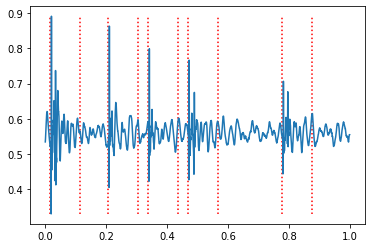

In [20]:
subsig, subbounds = signal_splice(sample, 1, 2, sr, boundaries_nleo)
plot_boundaries_on_signal(subsig, subbounds, sr)

### Short-Time Energy Zero Crossing:

In [12]:
boundaries_ezcr = ezcr_vad(sample, 0.01, 0.005)
print("Number of boundaries: ", len(boundaries_ezcr))
print("Boundary locations: ", boundaries_ezcr)

132.69413394652136 0.008333333333333333
157.98330798745155 0.0
156.32547694444656 0.0
147.7580322921276 0.0
149.59297940135002 0.0
157.36451882123947 0.0
157.35718101263046 0.0
148.29706451296806 0.0
140.5236056447029 0.0
140.93840539455414 0.0
146.7038080394268 0.0
154.57014030218124 0.0
160.6929867863655 0.0
158.2005262374878 0.0
145.3550220131874 0.0
141.26309069991112 0.0
155.4841192960739 0.0
165.6715985238552 0.0
153.71110448241234 0.0
138.42579606175423 0.0
135.5021714270115 0.0
142.58525720238686 0.0
156.06907752156258 0.0
163.42412385344505 0.0
156.53691247105598 0.0
146.42118334770203 0.0
143.01823008060455 0.0
151.47545075416565 0.0
165.7410469353199 0.0
161.84567537903786 0.0
140.43156930804253 0.0
129.0468566417694 0.0
138.42903703451157 0.0
158.92135727405548 0.0
168.43899297714233 0.0
154.53419530391693 0.0
140.43895971775055 0.0
145.6417786180973 0.0
155.3232398033142 0.0
159.9567781984806 0.0
150.8713396936655 0.0
154.61886408925056 0.0
156.6211253553629 0.0
135.292567

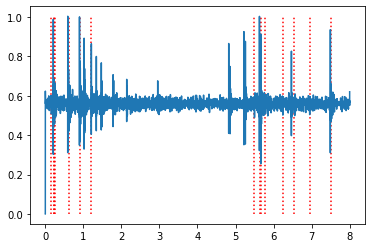

In [18]:
subsig_ezcr, subbounds_ezcr = signal_splice(sample, 0, 8, sr, boundaries_ezcr)
plot_boundaries_on_signal(subsig_ezcr, subbounds_ezcr, sr)